**Author: Bibek Prasad Gupta**

**Connect to google drive**

In [16]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [17]:
os.chdir('/content/drive/MyDrive/SparkIntern')

In [18]:
import pandas as pd
import numpy as np
data = pd.read_csv("merged_price_and_sentiments_data.csv")

In [19]:
print(data.columns)

Index(['Unnamed: 0', 'time', 'closed_price_by_day', 'price_diff', 'movement',
       'Daily_Weight_mean_by_day', 'Daily_Weight_count_by_day',
       'blob_sent_mean_by_day', 'subjectivity_mean_by_day',
       'vader_sent_mean_by_day', 'news_diff', 'blob_sent_mean_by_day_diff',
       'vader_sent_mean_by_day_diff', 'news_movement', 'blob_sent_movement',
       'vader_sent_movement'],
      dtype='object')


# Normalizing values

In [20]:
time_len = data.shape[0]
x = data.filter(['blob_sent_mean_by_day', 'subjectivity_mean_by_day','vader_sent_mean_by_day','closed_price_by_day','Daily_Weight_count_by_day',"movement"])

from sklearn import preprocessing

xx = x.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(xx)
#df = pd.DataFrame(x_scaled)
print(x_scaled)


[[0.26941377 0.21155412 0.41965887 0.32402647 0.57831325 0.        ]
 [0.29686181 0.50608546 0.61890852 0.32853715 0.34337349 1.        ]
 [0.30356941 0.26172291 0.24559863 0.33453235 0.51204819 1.        ]
 ...
 [0.26450303 0.46199101 0.57190915 0.82237063 0.37349398 0.        ]
 [0.19671027 0.28603092 0.36365738 0.8423547  0.30722892 1.        ]
 [0.36569569 0.3687874  0.66214024 0.83344754 0.3253012  0.        ]]


# Use series_to_supervised to get time series data

In [21]:

from sklearn.preprocessing import LabelEncoder

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# integer encode direction
encoder = LabelEncoder()
xx[:,3] = encoder.fit_transform(xx[:,3])
# ensure all data is float
xx = xx.astype('float32')
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(xx)
# frame as supervised learning
reframed = series_to_supervised(scaled, 2, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10]], axis=1, inplace=True)
print(reframed.head())


   var0(t-2)  var1(t-2)  var2(t-2)  ...   var3(t)   var4(t)  var5(t)
2   0.269414   0.211554   0.419659  ...  0.674687  0.512048      1.0
3   0.296862   0.506085   0.618908  ...  0.624639  0.463855      0.0
4   0.303569   0.261723   0.245599  ...  0.650626  0.487952      1.0
5   0.229803   0.288425   0.624440  ...  0.608277  0.572289      0.0
6   0.241443   0.306317   0.439056  ...  0.606352  0.439759      0.0

[5 rows x 15 columns]


# LSTM MODEL 


In [22]:
import keras
from keras.datasets import reuters, imdb
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, GRU, Dense, Dropout, Activation, Embedding, ConvLSTM2D,Bidirectional, Conv2D,Conv1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from keras import metrics as met2
import math
from numpy import concatenate

# train test split and reshaping

In [23]:
labels = reframed.values[:,-1]
#labels = labels.astype('int')
print(reframed.shape)
features = reframed.values[:,:8]
print(features.shape,labels.shape)
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
x_train = x_train.reshape((x_train.shape[0], 2, 4))
x_test = x_test.reshape((x_test.shape[0],2, 4))
print(x_train.shape)

(1132, 15)
(1132, 8) (1132,)
(905, 2, 4)


# Compiling model

In [24]:

# design network
#for i in range(1,10):
model = Sequential()
#model.add(Conv2D(100, 2, activation='relu'))
#model.add(SimpleRNN(32))
model.add(Bidirectional(LSTM(100), input_shape=(x_train.shape[1], x_train.shape[2])))
#model.add(ConvLSTM2D(2,kernel_size = (3,3),input_shape =(None,x_train.shape[1], x_train.shape[2],1) ,padding='same', return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))
model.compile(loss='binary_crossentropy', metrics=[met2.binary_accuracy], optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs=100, batch_size=100, validation_data=(x_test, y_test), verbose=0, shuffle=False)
# plot history
print(model.summary())



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 200)               84000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 84,201
Trainable params: 84,201
Non-trainable params: 0
_________________________________________________________________
None


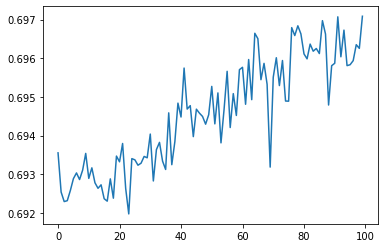

In [25]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.show()

# Evaluation

In [26]:
# make a prediction

#x_test = test_X.reshape((x_test.shape[0], x_test.shape[2]))
yhat = model.predict(x_test)
#print(yhat.score)
rmse = math.sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.497


In [27]:

#print(yhat[0:90])
yhat = yhat.astype("float64")
y2 = yhat
for i in range(yhat.shape[0]):
    if y2[i] >0.5:
        y2[i] = 1
    else:
        y2[i] = 0
matrix = metrics.confusion_matrix(y_test,yhat)
#acc = met2.binary_accuracy(y_test,keras.backend.round(yhat),threshold=0.5)
print(matrix)
#print(acc)

score = model.evaluate(x_test, y_test, batch_size=72, verbose=1)
print('Test score:', score[1])


[[52 50]
 [50 75]]
4/4 [==============================] - 0s 5ms/step - loss: 0.6864 - binary_accuracy: 0.5595
Test score: 0.5594713687896729
